Student Emails
====

Classify, learn stuff, etc.

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

from libEmails import read

First we'll try to classify the email subject lines into their demand categories.

We need to clean the data up a bit first; we need to decide how many emails per demand type to require (demand types rarer than this will be discarded):

In [2]:
sampling = "undersample"

In [3]:
min_num_labels = 75

(
    (X_train, categories_train),
    (X_test, categories_test),
    vectorizer,
) = read.read_email_subjects(
    min_num_labels, verbose=True, sampling=sampling, return_vectorizer=True
)

Dropping 66 NaN values of 7500
{'Absence/Attendance': 257,
 'Admissions': 30,
 'Appeal': 164,
 'Arrival': 29,
 'Blackboard': 88,
 'Certificates and Transcripts': 52,
 'Course Information': 33,
 'Course Transfer': 625,
 'Degree Classification': 9,
 'Document Request': 53,
 'Exams and Assessments': 1858,
 'Extension': 337,
 'Extenuating Circumstances': 104,
 'Graduation': 7,
 'Miscellaneous': 1362,
 'Online learning ': 229,
 'Personal Tutoring ': 96,
 'Placement': 14,
 'Plagiarism': 15,
 'Registration': 194,
 'Student Finance': 48,
 'Student Support and Wellbeing': 161,
 'Student Visa': 39,
 'Study Skills': 7,
 'Supplementary Year ': 66,
 'Suspension': 268,
 'Timetable': 370,
 'Tutorial': 19,
 'Unit Evaluation': 10,
 'Unit change/choices': 805,
 'Welcome Week': 15,
 'Withdrawal': 25,
 'Year Abroad': 45}
Following categories will be removed; fewer than the minimum (75) found:
{'Admissions': 30,
 'Arrival': 29,
 'Certificates and Transcripts': 52,
 'Course Information': 33,
 'Degree Classi

Now we have a bag of words (`X_train`) and some labels (`categories_train`); we can use these to train a classifier:

In [4]:
def classifiers():
    return [
        MultinomialNB(),
        RandomForestClassifier(),
        SGDClassifier(loss="modified_huber", penalty="l1", max_iter=100, alpha=0.0001),
    ]


subject_clfs = classifiers()
for c in subject_clfs:
    c.fit(X_train, categories_train)

In [5]:
def print_info(clf, values, labels):
    print(f"{type(clf).__name__}:")
    print(metrics.classification_report(labels, clf.predict(values)))
    cv_test = cross_validate(
        clf,
        values,
        labels,
        scoring="balanced_accuracy",
    )
    print(
        f"Balanced accuracy {cv_test['test_score'].mean():.4f}+-{cv_test['test_score'].std():.4f}\n{'-' * 79}"
    )


# Print a classification report for the test data
for c in subject_clfs:
    print_info(c, X_test, categories_test)

MultinomialNB:
                               precision    recall  f1-score   support

           Absence/Attendance       0.53      0.85      0.65        55
                       Appeal       0.40      1.00      0.57        29
                   Blackboard       0.23      1.00      0.37        19
              Course Transfer       0.82      0.94      0.88       154
        Exams and Assessments       0.92      0.62      0.74       463
                    Extension       0.73      0.96      0.83        85
    Extenuating Circumstances       0.32      1.00      0.48        23
                Miscellaneous       0.80      0.35      0.49       337
             Online learning        0.64      0.97      0.77        64
           Personal Tutoring        0.79      1.00      0.88        30
                 Registration       0.73      0.89      0.81        65
Student Support and Wellbeing       0.71      0.89      0.79        45
                   Suspension       0.84      0.96      0.89 

We can also run the classifier on arbitrary strings:

In [6]:
# Just some functions for plotting
def _predict(clfs: tuple, X: csr_matrix):
    """
    Predict the label for a sparse matrix repr of a bag of words using a tuple of classifiers

    Returns (class names, probabilities) for each classifier

    """
    # Could use a zip expression here but this is nicer
    return [c.predict(X)[0] for c in clfs], [c.predict_proba(X)[0] for c in clfs]


def _plot_bars(ax: plt.Axes, class_probabilities: list, all_classes: list):
    """
    Plot a bar chart of the classification probabilities for each classifier

    """
    width = 1 / (len(class_probabilities) + 1)
    x = np.arange(len(class_probabilities[0]))
    for i, p in enumerate(class_probabilities):
        ax.barh(x + i * width, p, height=width, tick_label=all_classes)
    ax.set_xlim(0.0, 1.1)


def _plot_info(
    ax: plt.Axes, classifier_names: list, predicted_classes: list, confidence
):
    """
    Print info about the classifiers on a plot

    """
    ax.axis("off")
    matplotlib_colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    for i, (c, name, pred_class, percent) in enumerate(
        zip(matplotlib_colours, classifier_names, predicted_classes, confidence)
    ):
        y = 0.2 + 0.15 * i
        ax.text(
            0.2,
            y,
            f"{name}:{' ' * 4}{pred_class}, {100 * percent:3.1f}%",
            color=c,
            fontsize=16,
        )

changing my course


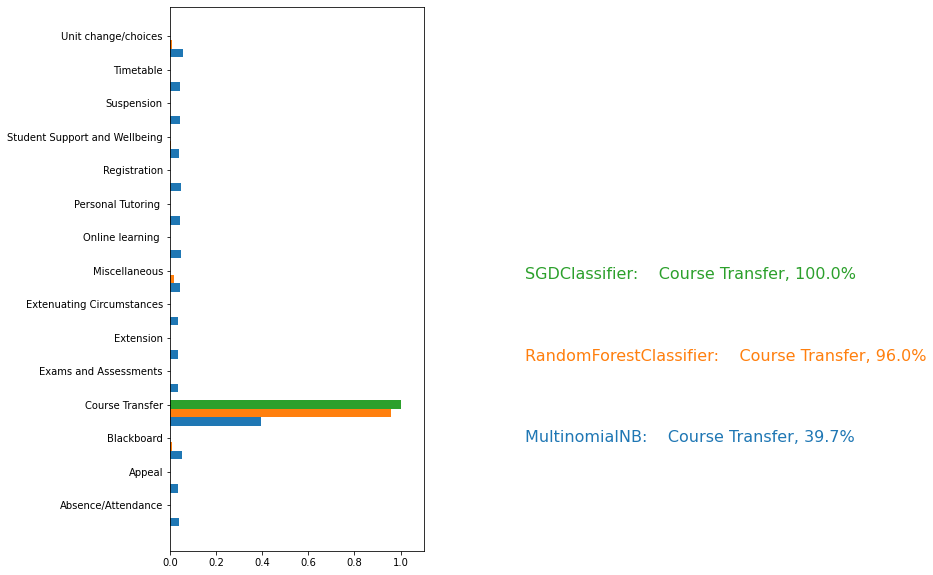

issue with tutor


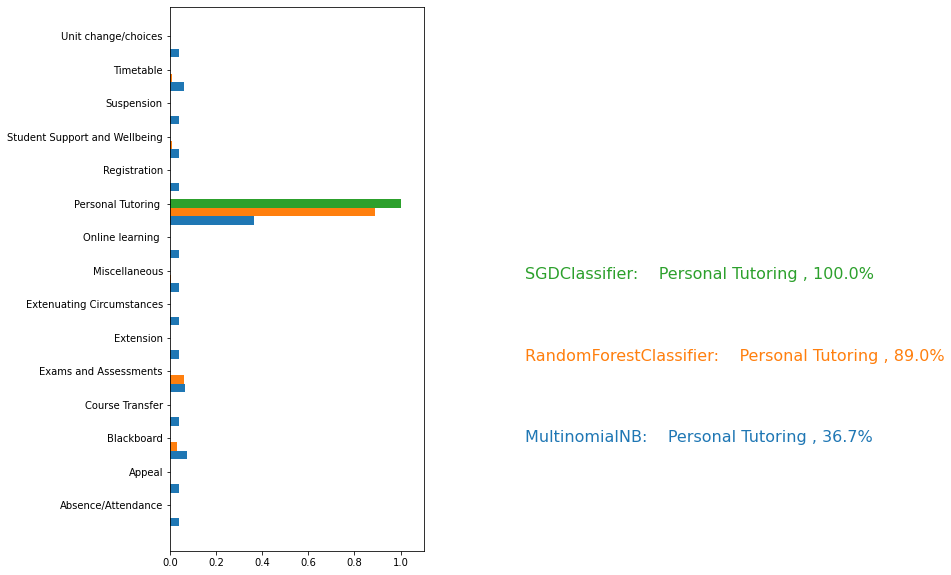

In [7]:
all_classes = np.unique(categories_train)
s = input()
while s:
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    X: csr_matrix = vectorizer.transform([s])

    predicted_labels, probabilities = _predict(subject_clfs, X)

    confidence = [np.max(x) for x in probabilities]

    _plot_bars(ax[0], probabilities, all_classes)
    _plot_info(
        ax[1], [type(c).__name__ for c in subject_clfs], predicted_labels, confidence
    )
    plt.show()
    s = input()

We can also attempt to classify the email bodies similarly; we will put the email body and subject line into a single bag of words.

We will need to use a smaller minimum since this dataset only contains 200 emails.

In [8]:
min_num_labels = 13
(X_train, categories_train), (X_test, categories_test) = read.read_email_body(
    min_num_labels, verbose=True, sampling=sampling
)

EmailBody:	Dropping 1 NaN values of 200
Subject:	Dropping 0 NaN values of 200
{'Academic': 10,
 'Attendance': 11,
 'Awards/Graduation Certificate': 8,
 'Change of Circumstances': 5,
 'Course Transfer': 8,
 'Dissertations/Coursework': 29,
 'Exams/Resits': 41,
 'Extenuating Circumstances': 11,
 'Funding': 1,
 'General': 4,
 'Late Coursework/Penalties': 3,
 'Marks & Feedback': 9,
 'Misc Enquiry': 7,
 'Misc Student Data/Process Errors': 3,
 'Online Learning': 12,
 'Plagiarism & Collusion': 2,
 'Progression': 2,
 'Student Status Letter': 2,
 'Timetables': 5,
 'Transcripts': 3,
 'Tuition / Accommodation Fees': 2,
 'Unit Choices': 18,
 'University Email Account': 1,
 'Visa': 2}
Following categories will be removed; fewer than the minimum (13) found:
{'Academic': 10,
 'Attendance': 11,
 'Awards/Graduation Certificate': 8,
 'Change of Circumstances': 5,
 'Course Transfer': 8,
 'Extenuating Circumstances': 11,
 'Funding': 1,
 'General': 4,
 'Late Coursework/Penalties': 3,
 'Marks & Feedback': 9,

In [9]:
body_clfs = [SGDClassifier()]
for c in body_clfs:
    c.fit(X_train, categories_train)

In [10]:
for c in body_clfs:
    print_info(c, X_test, categories_test)

SGDClassifier:
                          precision    recall  f1-score   support

Dissertations/Coursework       1.00      0.90      0.95        10
            Exams/Resits       1.00      1.00      1.00         7
            Unit Choices       0.86      1.00      0.92         6

                accuracy                           0.96        23
               macro avg       0.95      0.97      0.96        23
            weighted avg       0.96      0.96      0.96        23

Balanced accuracy 0.9000+-0.1333
-------------------------------------------------------------------------------
